#### Создаем  и активируем виртуальное окружение 

#### Импортируем бибилотеки

In [2]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Поключаем MLflow для логирования экспов 

In [5]:
# mlflow.sklearn.autolog()

#### Функция для вывода MLflow UI в виде страницы браузера

In [6]:
# mlruns_path = os.path.abspath("./mlruns/0")
# print(mlruns_path)

In [7]:
# import subprocess
# import webbrowser
# import os
# import time

# def start_mlflow_ui(port=5000, backend_store_uri=None):
#     """
#     Запускает MLflow UI и открывает браузер
#     """
#     # Создаем директорию, если её нет
#     if backend_store_uri and backend_store_uri.startswith("file://"):
#         dir_path = backend_store_uri.replace("file://", "")
#         os.makedirs(dir_path, exist_ok=True)
#         print(f"Using storage: {dir_path}")
    
#     command = ["mlflow", "ui", "--port", str(port)]
    
#     if backend_store_uri:
#         command.extend(["--backend-store-uri", backend_store_uri])
    
#     print(f"Running command: {' '.join(command)}")
    
#     # Запускаем процесс
#     process = subprocess.Popen(command)
    
#     time.sleep(3)
#     webbrowser.open(f"http://localhost:{port}")
    
#     return process


# # Вариант 2: с абсолютным путем (лучше)
# mlruns_abs_path = os.path.abspath("./mlruns")
# ui_process = start_mlflow_ui(port=5001, backend_store_uri=f"file://{mlruns_abs_path}")

# # Вариант 3: без указания хранилища (использует ./mlruns по умолчанию)
# # ui_process = start_mlflow_ui(port=5000)

# try:
#     ui_process.wait()
# except KeyboardInterrupt:
#     print("Остановка MLflow UI...")
#     ui_process.terminate()

#### Загружаем датасет

In [9]:
df = pd.read_csv('podcasts.csv')

In [ ]:
df.head(2)

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559


In [ ]:
#Смотрим размерность датасета
df.shape

(52500, 11)

In [10]:
#выводим основные стат.показатели датасета. 
df.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,47254.000000,52500.000000,47242.000000,52500.000000,47105.000000
mean,62.853491,60.163949,50.053434,1.497962,45.560293
std,33.137428,23.158567,28.884997,1.117412,27.182454
min,5.000000,20.000000,0.010000,0.000000,0.000000
25%,34.300000,40.000000,25.030000,0.000000,23.286442
50%,62.870000,60.300000,50.035000,1.000000,43.555490
75%,91.550000,80.310000,75.100000,2.000000,64.953793
max,120.000000,100.000000,100.000000,3.000000,119.970000


Все представленные фичи, а также целевой таргет имеют сопоставимый мастшаб распределения данных
Значит препроцессинг связанный масштабированием нам не нужен будет в дальнейшем

In [11]:
#валидируем датасет на пропуски и удаляем если их доля на тотале не превышает 15%
print(f"Пропуски в данных \n{df.isna().sum()}")
print('======================')

def check_null(df):
    view_null = np.round(df.isna().sum().max()/df.shape[0] * 100)
    if view_null < 15:
        print(f"Доля {np.round(df.isna().sum().max()/df.shape[0] * 100)}% пропусков")
        if df.dropna().shape[0] < df.shape[0]*0.85:
             print('НО доля пропусков на тотале сильно больше 15%. Будем заполнять пропуски')
             return df
        else:
            print('Lоля пропусков на тотале меньше  20%. Удаляем пропуски')
            return df.dropna()
    else:
        print('Меньше 20%')
        return df

df = check_null(df)

Пропуски в данных 
Podcast_Name                      0
Episode_Title                     0
Episode_Length_minutes         5246
Genre                             0
Host_Popularity_percentage        0
Publication_Day                   0
Publication_Time                  0
Guest_Popularity_percentage    5258
Number_of_Ads                     0
Episode_Sentiment                 0
Listening_Time_minutes         5395
dtype: int64
Доля 10.0% пропусков
НО доля пропусков на тотале сильно больше 15%. Будем заполнять пропуски


In [12]:
#Смотрим на наличие дубликатов в данных

df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
52495     True
52496     True
52497     True
52498     True
52499     True
Length: 52500, dtype: bool

In [13]:
#Выборка одной пару дубликатов
df[(df['Podcast_Name'] == 'Business Briefs')& (df['Episode_Title'] == "Episode 85") & (df['Listening_Time_minutes'] == 17.220998)]

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
8484,Business Briefs,Episode 85,NaN,Business,41.47,Wednesday,Afternoon,33.58,0,Neutral,17.220998
52498,Business Briefs,Episode 85,NaN,Business,41.47,Wednesday,Afternoon,33.58,0,Neutral,17.220998


Т.к. у нас датасет представляет собой агрегированную информацию по прослушиваниям подкастов, то велика вероятность того, что были пользователя прослушавшие одинаковое кол-во времени. 
На данном этапе пока дубликаты оставляем

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 52500 non-null  object 
 1   Episode_Title                52500 non-null  object 
 2   Episode_Length_minutes       47254 non-null  float64
 3   Genre                        52500 non-null  object 
 4   Host_Popularity_percentage   52500 non-null  float64
 5   Publication_Day              52500 non-null  object 
 6   Publication_Time             52500 non-null  object 
 7   Guest_Popularity_percentage  47242 non-null  float64
 8   Number_of_Ads                52500 non-null  int64  
 9   Episode_Sentiment            52500 non-null  object 
 10  Listening_Time_minutes       47105 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 4.4+ MB


In [15]:
numeric_features_columns = df.select_dtypes(np.number).columns
cat_features_columns = df.select_dtypes(object).columns
target_column = 'Listening_Time_minutes'

In [16]:
def looking_into_numeric_features(data, num_col):
    
    n_cols = 3
    n_rows = (len(numeric_features_columns) + n_cols) // 3
    plt.figure(figsize=(18,10))
    
    for i, feature in enumerate(numeric_features_columns):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(data, x=feature)
        plt.xlabel(feature)
        plt.ylabel("Плотность")
        plt.title("Распределение основны кол-ых фичей")        

In [17]:
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


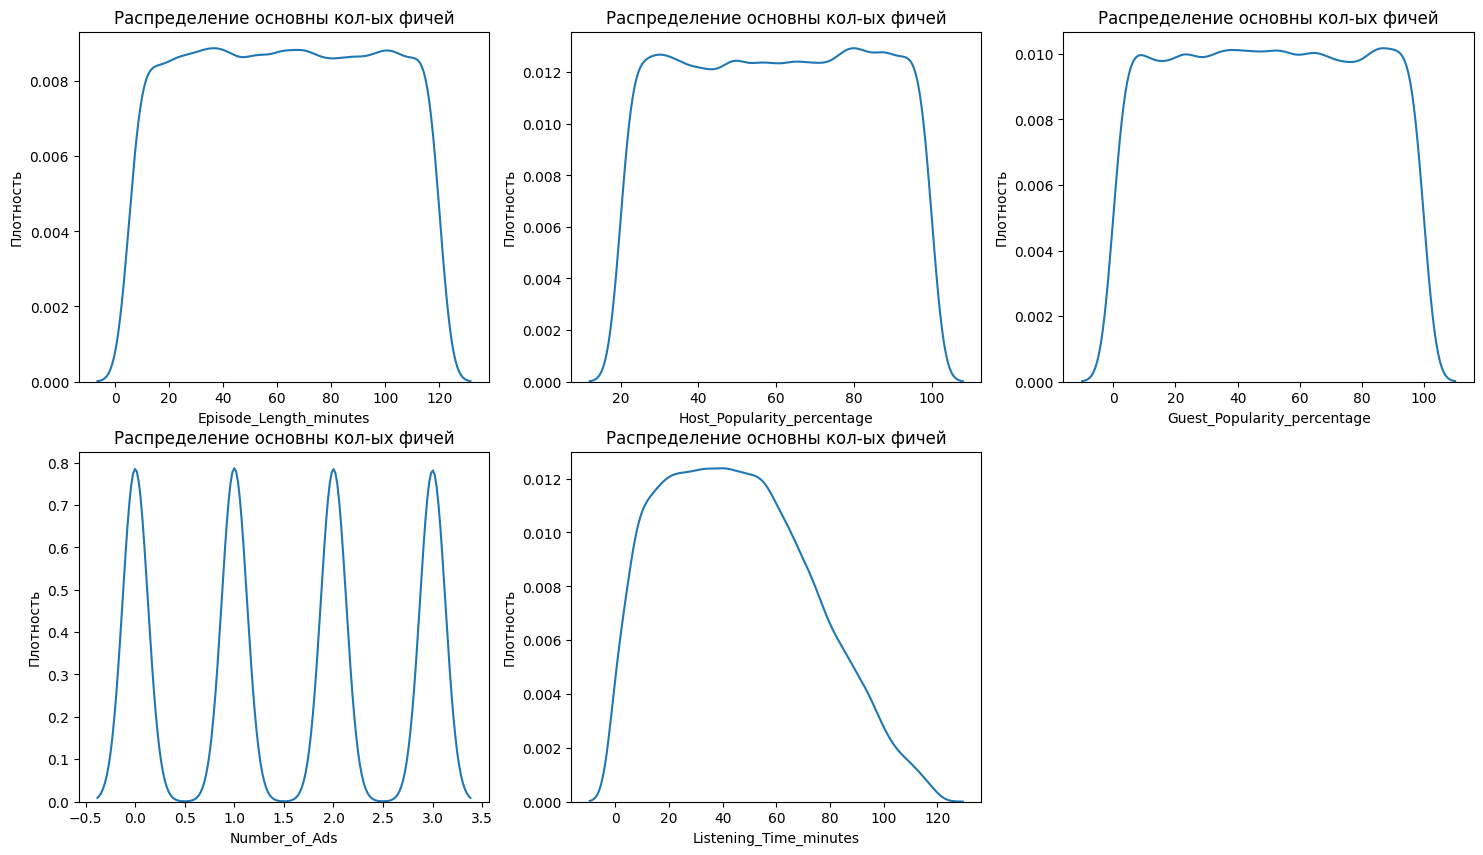

In [18]:
looking_into_numeric_features(df, numeric_features_columns)

Видим, что плотность распределений везде практически идентична.

Во времени прослушивания видим, смещение распределения влево т.е. большая часть прослушиваний подкастов пользователями краткосрочна т.к. длина подкастов по времени у нас в целом распределено равномерно. 



In [19]:
#Построим графики для определения существующих зависимостей основных независимых признаков с целевым таргетом
def plots_correlation_numeric_features_with_target(data, num_col):
    num_col = num_col.to_list()
    num_col.remove('Listening_Time_minutes')
    target = 'Listening_Time_minutes'
    n_cols = 3
    n_rows = (len(num_col) + n_cols) // 3
    plt.figure(figsize=(18,10))
    
    for i, feature in enumerate(num_col):
        plt.subplot(n_rows, n_cols, i+1)
        plt.scatter(data[feature], data[target])
        plt.xlabel(feature)
        plt.ylabel("Время прослушивания")
        plt.title(f"Зависимость {target} от {feature}")        

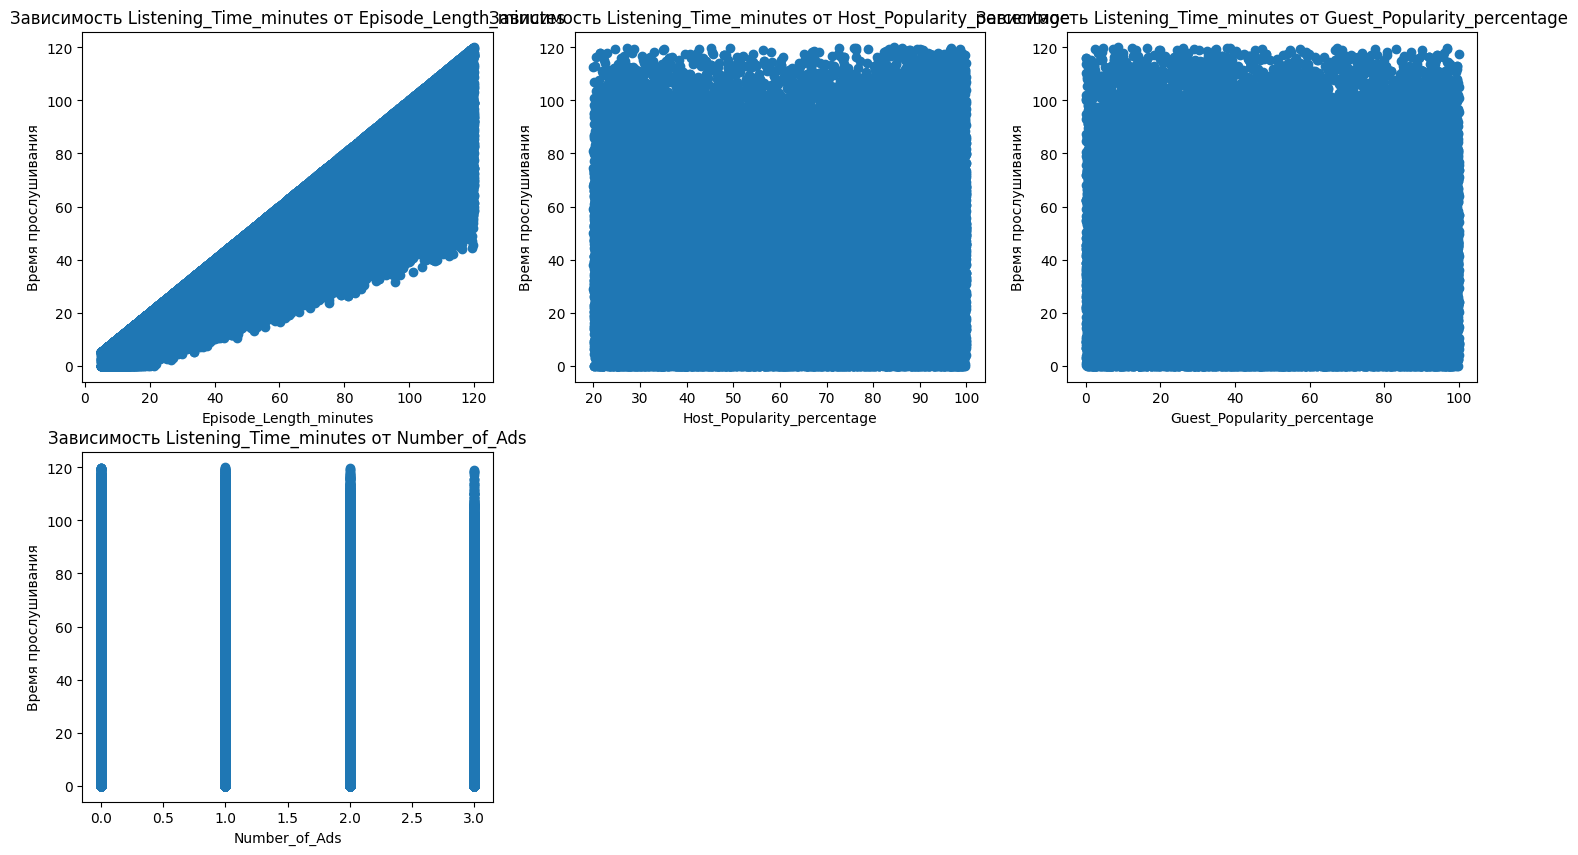

In [20]:
plots_correlation_numeric_features_with_target(data=df, num_col=numeric_features_columns)

С целевым таргетом коррелирует продолжительность подкаста. Рассмотрим на сколько сильна эта связь

<Axes: >

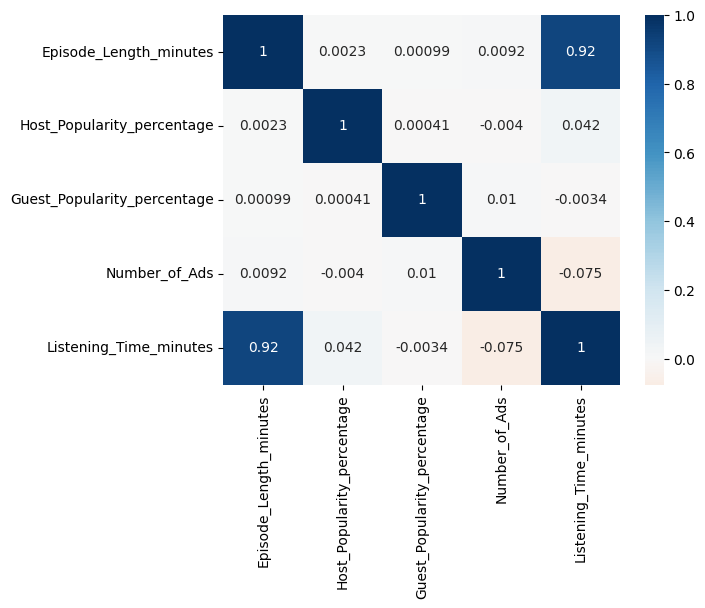

In [21]:
#Строим корреляционную темпловую карту

sns.heatmap(data=df[numeric_features_columns].corr(method='spearman'), annot=True, cmap='RdBu', center=0)

### Наблюдаем сильную корреляцию таргета с длительностью подкаста = 0.92. 

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [24]:
def search_multicollinear(df):
    """Функция вычисляющая Фактор инфляции дисперсии (VIF) и сигнализирует о наличии и силы мультиколлинеарности у независимых фич"""
    df = df[numeric_features_columns].drop(labels=['Listening_Time_minutes'], axis=1) # выбираем кол-ые признаки, удаляем таргет
    df = df.fillna(df.mean()) # обрабатываем пропуски в данных
    X_with_const = add_constant(df) #добавляем константу в датафрейм т.к. VIF не работает с пропусками
    X_features = X_with_const.columns  #определяем названия колонок фичей
    vif_df = pd.DataFrame() # формируем пустой датафрейм для организации расчетных  итоговых цифр 
    vif_df['feature'] = X_features # заполняем датафрейм названиями независимых фич
    vif_df['VIF'] = [variance_inflation_factor(X_with_const.values,i)  for i in range(X_with_const.shape[1])] #посредством list comprehension записываем итоговые VIF коэффициенты в датафрейм 
    #валидация итоговых результатов
    print('=================================================================')
    if vif_df.iloc[1:,:].max()[1] > 10:
        print("Присутствует сильная мультиколлинеарность")
    elif vif_df.iloc[1:,:].max()[1] < 10 and vif_df.iloc[1:,:].max()[1] > 5:
        print("Присутствует умеренная мультиколлинеарность")
    else:
        print("Мультиколлинеарность незначительная или отсутствует вовсе ")
    print('=================================================================')

    return vif_df # возвращаем VIF коэффициенты по каждой фиче


print(search_multicollinear(df))



Мультиколлинеарность незначительная или отсутствует вовсе 
                       feature        VIF
0                        const  16.782010
1       Episode_Length_minutes   1.000081
2   Host_Popularity_percentage   1.000021
3  Guest_Popularity_percentage   1.000096
4                Number_of_Ads   1.000187


/var/folders/py/y2s4dn6x3_x0nwh8f_w5r68w0000gn/T/ipykernel_19022/2962417323.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if vif_df.iloc[1:,:].max()[1] > 10:
/var/folders/py/y2s4dn6x3_x0nwh8f_w5r68w0000gn/T/ipykernel_19022/2962417323.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif vif_df.iloc[1:,:].max()[1] < 10 and vif_df.iloc[1:,:].max()[1] > 5:
/var/folders/py/y2s4dn6x3_x0nwh8f_w5r68w0000gn/T/ipykernel_19022/2962417323.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

### Мультиколлинеарность независимых признаков около нулевая. 

Рассмотрим распределение категориальных фичей 

In [25]:
def categorial_feat_boxplots(data, cat_feat, target):
    plt.figure(figsize=(40,30))
    num_col = 3
    n_rows = len(cat_feat) // 3 + 1
    for ind, feature in enumerate(cat_feat):
        plt.subplot(n_rows, num_col, ind +1)
        sns.boxplot(data, x=feature, y='Listening_Time_minutes')
        plt.xlabel(feature)
        plt.xticks(rotation=45)
        plt.title(feature)
    plt.show()
    

<Axes: xlabel='Genre', ylabel='count'>

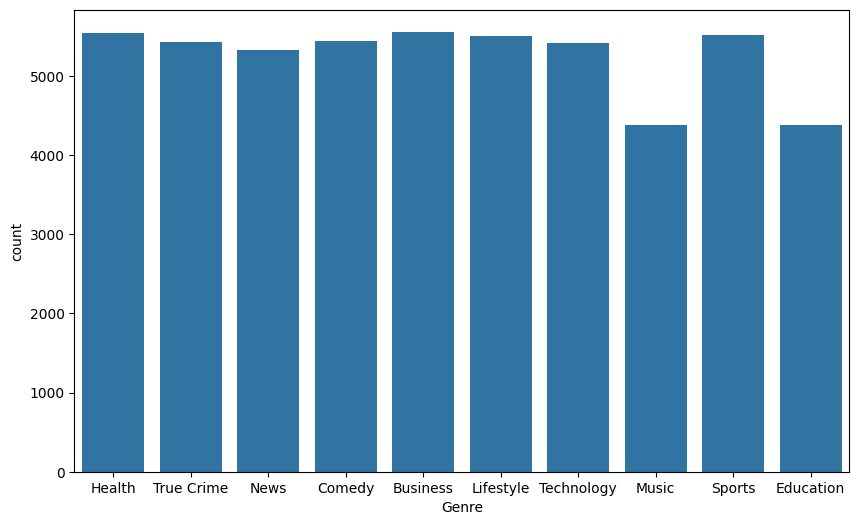

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(df, x='Genre')

In [27]:
df.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559
2,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3,Neutral,110.064645
3,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive,12.000380
4,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive,NaN


<Axes: xlabel='Genre', ylabel='Listening_Time_minutes'>

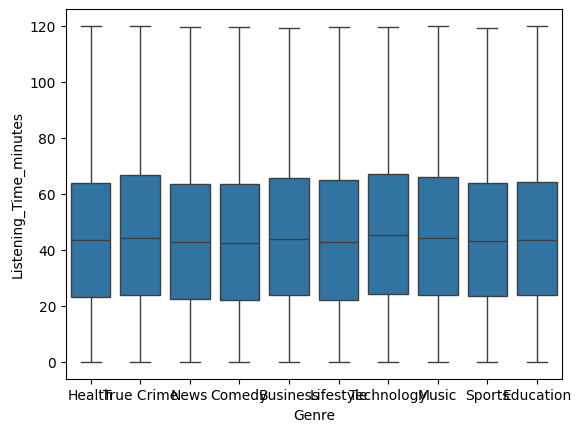

In [28]:
sns.boxplot(data=df, x='Genre', y='Listening_Time_minutes')

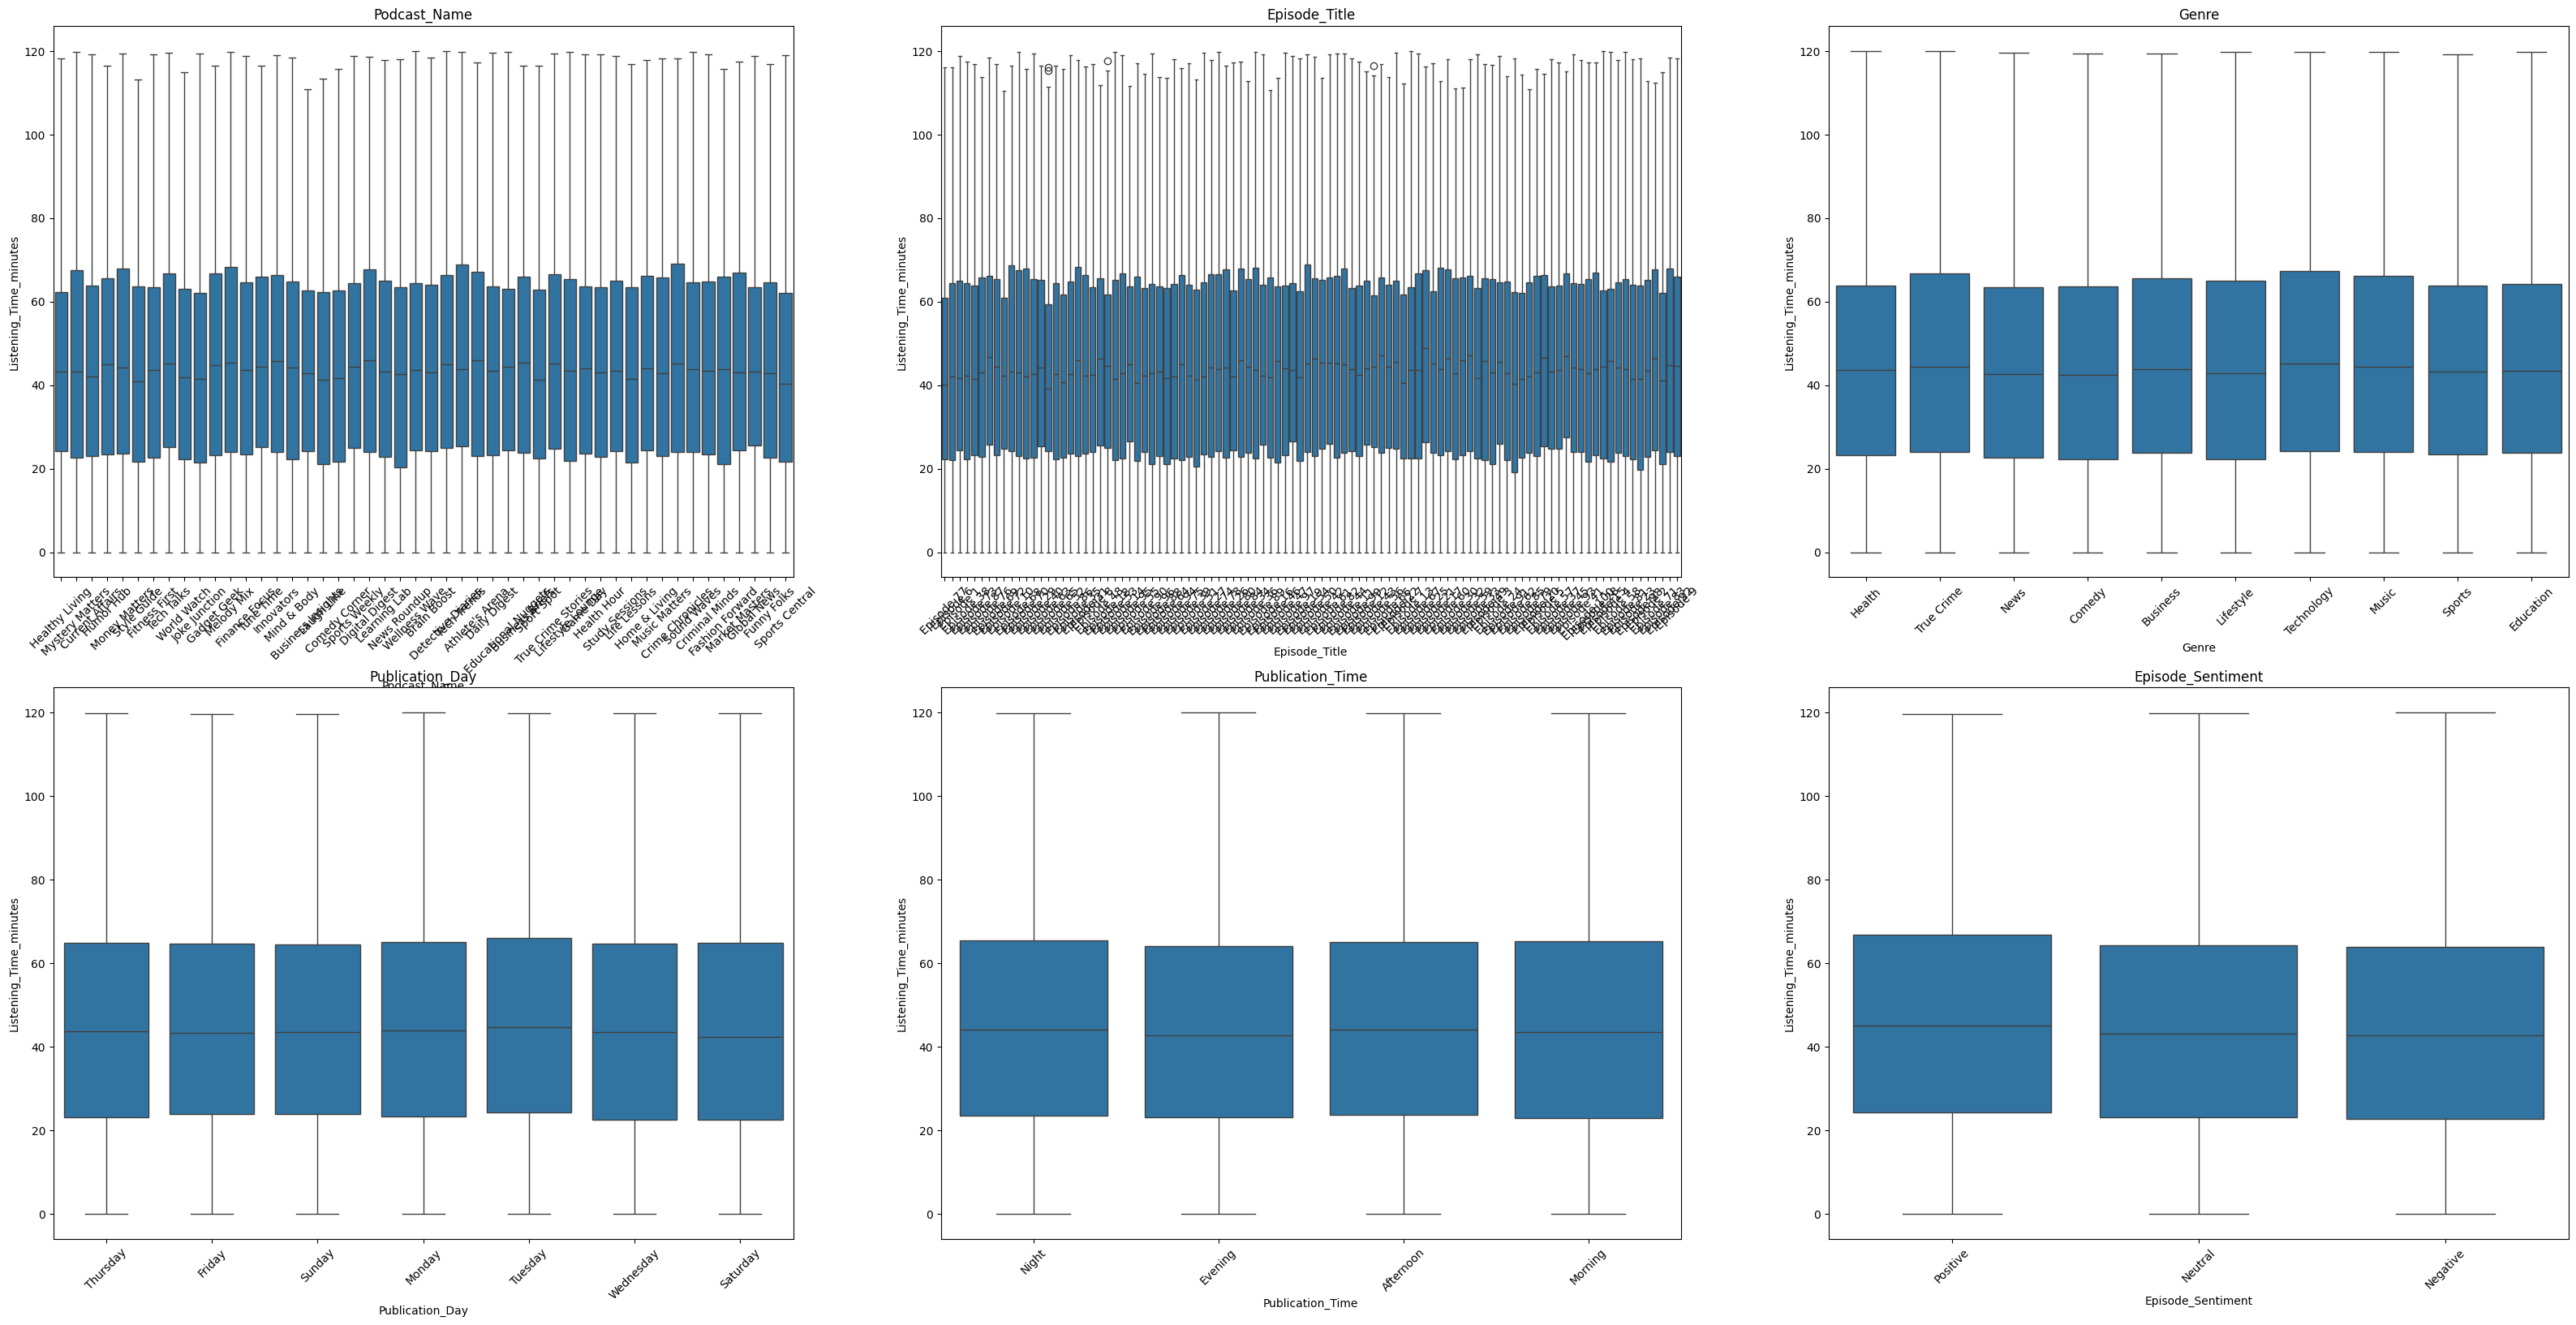

In [29]:
categorial_feat_boxplots(data=df, cat_feat=cat_features_columns, target=target_column)

In [30]:
df[cat_features_columns]['Podcast_Name'].unique()

array(['Healthy Living', 'Mystery Matters', 'Current Affairs',
       'Humor Hub', 'Money Matters', 'Style Guide', 'Fitness First',
       'Tech Talks', 'World Watch', 'Joke Junction', 'Gadget Geek',
       'Melody Mix', 'Finance Focus', 'Tune Time', 'Innovators',
       'Mind & Body', 'Business Insights', 'Laugh Line', 'Comedy Corner',
       'Sports Weekly', 'Digital Digest', 'Learning Lab', 'News Roundup',
       'Wellness Wave', 'Brain Boost', 'Detective Diaries', 'Tech Trends',
       "Athlete's Arena", 'Daily Digest', 'Educational Nuggets',
       'Business Briefs', 'Sport Spot', 'True Crime Stories',
       'Lifestyle Lounge', 'Game Day', 'Health Hour', 'Study Sessions',
       'Life Lessons', 'Home & Living', 'Music Matters',
       'Crime Chronicles', 'Sound Waves', 'Criminal Minds',
       'Fashion Forward', 'Market Masters', 'Global News', 'Funny Folks',
       'Sports Central'], dtype=object)

## Строим BASELINE model - линейную регрессию

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [92]:

def make_pipeline_preprocessor_and_model(num_col, cat_col, model_class, target=None, params=None, scaler=False, only_num_feat=False, only_cat_feat=False):
    num_col = num_col.to_list()
    num_col.remove('Listening_Time_minutes')
    if scaler:
        num_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                             ('scaler', StandardScaler())])
    else:
        num_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
    if only_num_feat:
        model = Pipeline([('preproc', num_pipe),
                      ('model', model_class(**params))])
        return model
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False))])
    preprocessor = ColumnTransformer([('num', num_pipe, num_col),
                                      ('cat', cat_pipe, cat_col)])
    if params is not None:
        model = Pipeline([('preprocessor', preprocessor),
                      ('model', model_class(**params))])
    else:
        model = Pipeline([('preprocessor', preprocessor),
                      ('model', model_class())])
    if target is not None:
        imputer = SimpleImputer(strategy='mean')
        if isinstance(target, pd.Series):
            target = imputer.fit_transform(target.to_frame())
        else:
            target = imputer.fit_transform(target) #.values.reshape(-1,1)
        return model, imputer.fit_transform(target)
    return model

In [93]:
# формируем тестовую и тренировочную выборки
X, y = df.drop(labels=['Listening_Time_minutes'], axis=1), df['Listening_Time_minutes']

#Создаем pipeline линейной регрессии с препроцессором фичей

model, y = make_pipeline_preprocessor_and_model(num_col=numeric_features_columns, cat_col=cat_features_columns, model_class=LinearRegression, target=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [94]:
#обучаем простую модель линейной регрессии
model.fit(X_train, y_train)

2025/09/03 00:03:35 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8166fd3d4dcc4fb8b249464c1f5dd86b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/09/03 00:03:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [95]:
#предсказываем таргет
y_pred = model.predict(X_test)

2025/09/03 00:03:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [96]:
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

In [97]:
#валидируем предсказания и реальные таргетные значения
def show_all_regressor_metrics(y_pred, y_test):
    print(f"R2 - {r2_score(y_test, y_pred)}")
    print(f"MSE - {mean_squared_error(y_test, y_pred)}")
    print(f"RMSE - {root_mean_squared_error(y_test, y_pred)}")
    print(y_test.mean())


show_all_regressor_metrics(y_pred=y_pred, y_test=y_test)

R2 - 0.6644891553263372
MSE - 222.89598051403334
RMSE - 14.929701286832008
45.50606824061257


Модель довольно неплохо аппроксимирует фактические данные = 66%, ошибается  на 1/3 кейсах

Text(0.5, 1.0, 'Валидация точности предсказаний обученной простой линейной модели')

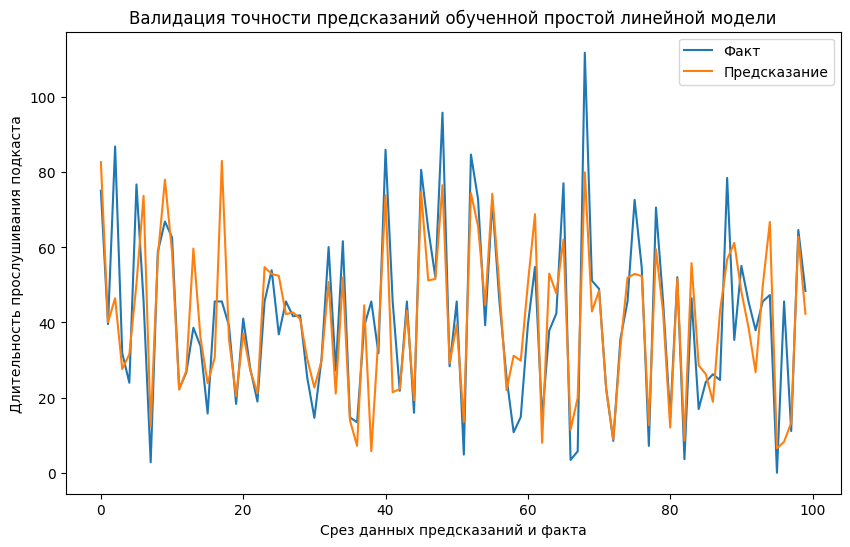

In [98]:
#Постром простую визуализацию для валидации качества предсказний модели
plt.figure(figsize=(10,6))
plt.plot(y_test[:100], label='Факт')
plt.plot(y_pred[:100], label='Предсказание')
plt.xlabel('Срез данных предсказаний и факта')
plt.ylabel('Длительность прослушивания подкаста')
plt.legend()
plt.title("Валидация точности предсказаний обученной простой линейной модели")

In [99]:
# # Запуск с настройками по умолчанию
# ui_process = start_mlflow_ui(backend_store_uri="file://mlruns")

# # try:
#     # Держим процесс активным
# ui_process.wait()
# except KeyboardInterrupt:
#     print("Остановка MLflow UI...")
#     ui_process.terminate()

In [100]:
from sklearn.linear_model import SGDRegressor

params_sgd_regressor = {
    'loss': 'squared_error',
    'penalty': 'l2',
    'max_iter': 1000,
    'alpha': 0.0001
}

model = make_pipeline_preprocessor_and_model(num_col=numeric_features_columns, cat_col=cat_features_columns, model_class=SGDRegressor, target=None, params=params_sgd_regressor,scaler=True)

model.fit(X_train, y_train)

2025/09/03 00:03:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd1e2eb5c3fc541f18a50f53d57a42f4a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/09/03 00:03:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [101]:
y_pred = model.predict(X_test)

2025/09/03 00:03:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [102]:
show_all_regressor_metrics(y_test=y_test, y_pred=y_pred)

R2 - 0.6643178962688299
MSE - 223.009756137537
RMSE - 14.933511179141261
45.50606824061257


Text(0.5, 1.0, 'Валидация точности предсказаний обученной простой линейной модели')

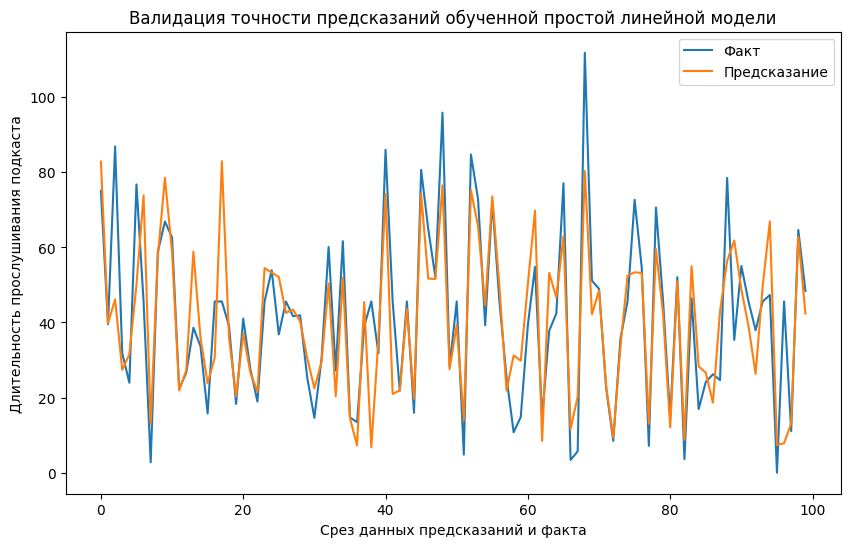

In [103]:
#Постром простую визуализацию для валидации качества предсказний модели
plt.figure(figsize=(10,6))
plt.plot(y_test[:100], label='Факт')
plt.plot(y_pred[:100], label='Предсказание')
plt.xlabel('Срез данных предсказаний и факта')
plt.ylabel('Длительность прослушивания подкаста')
plt.legend()
plt.title("Валидация точности предсказаний обученной простой линейной модели")

### Напишем собственную реализацию градиентного спуска для линейной регрессии

In [104]:
class NewLinearRegression:
    def __init__(self, loss='mse', learning_rate=0.01, n_iters=1000):
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None 
        self.loss_history = []

    def fit(self, X, y):
        # Преобразование разреженных матриц в плотные
        if hasattr(X, 'toarray'):
            X = X.toarray()
       
        y = np.array(y).flatten()
        
        # Проверка размерности
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        n_samples, n_features = X.shape

        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            y_pred = np.dot(X, self.weights) + self.bias

            error = y_pred - y

            loss = np.mean(error**2)
            self.loss_history.append(loss)
            

            dw = (2/n_samples) * np.dot(X.T, error)
            db = (2/n_samples) * np.sum(error)

            self.weights -= self.learning_rate * dw
            self.bias -=self.learning_rate * db
        return self
        
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def plot_loss(self):
        plt.figure(figsize=(10,6))
        plt.plot(self.loss_history)
        plt.title(f'Градиентный спуск ({self.loss.upper()})')
        plt.xlabel('Итерация')
        plt.ylabel('Значение потерь')
        plt.grid(True)
        plt.show()

In [105]:
params_grad = {
    'loss':'mse',
    'learning_rate':0.001,
    'n_iters':800
}

In [106]:
model_gradient, y = make_pipeline_preprocessor_and_model(num_col=numeric_features_columns, cat_col=cat_features_columns, target=y, model_class=NewLinearRegression, params=params_grad, scaler=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [107]:
model_gradient['model']

In [108]:
model_gradient.fit(X_train, y_train)

2025/09/03 00:03:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '702c06f1957243c7801cacad780dfb97', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/09/03 00:03:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [109]:
y_pred = model_gradient.predict(X_test)

/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
2025/09/03 00:03:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) 

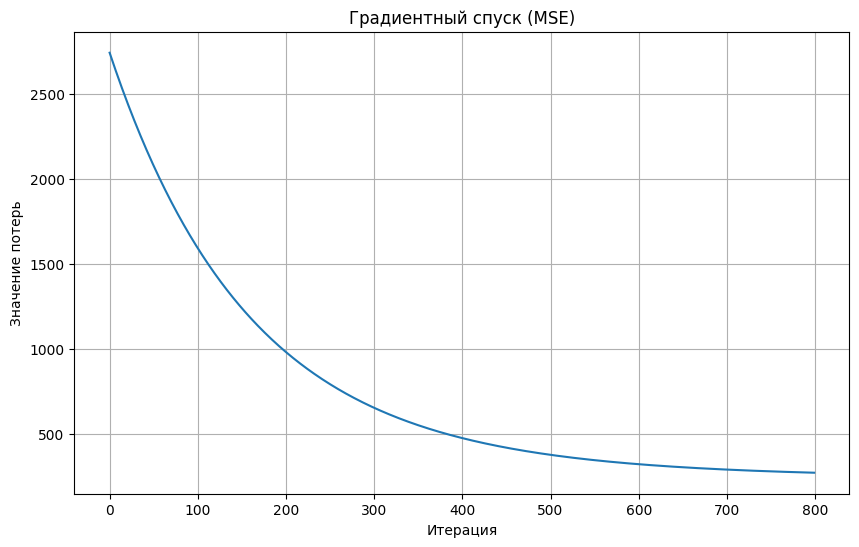

In [110]:
model_gradient['model'].plot_loss()

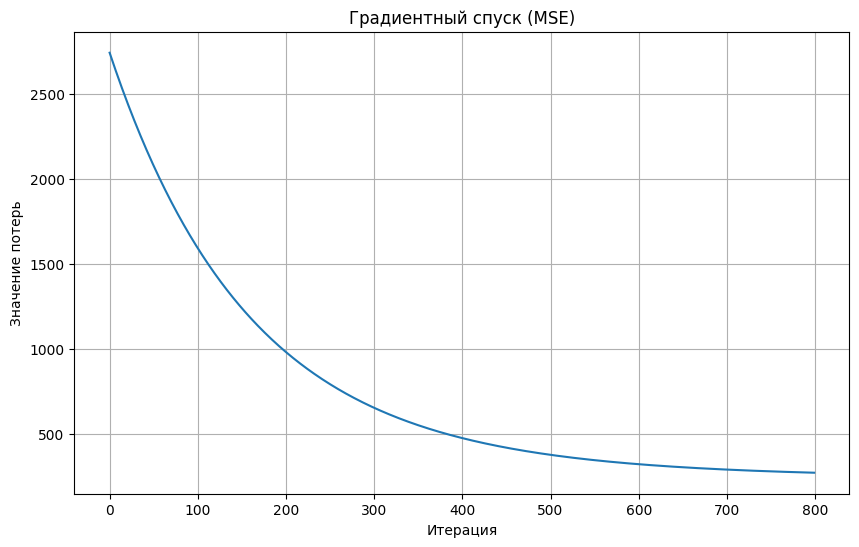

In [111]:
model_gradient['model'].plot_loss()

In [112]:
show_all_regressor_metrics(y_pred=y_pred, y_test=y_test)

R2 - 0.5884015460169906
MSE - 273.4446365447241
RMSE - 16.536161481574982
45.50606824061257


In [113]:
params_grad = {
    'loss':'mse',
    'learning_rate':0.1,
    'n_iters':500
}

In [114]:
model_gradient_scale, y = make_pipeline_preprocessor_and_model(num_col=numeric_features_columns, cat_col=cat_features_columns, target=y, model_class=NewLinearRegression, params=params_grad, scaler=True)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [116]:
model_gradient_scale.fit(X_train, y_train)

2025/09/03 00:03:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2e277b54e3654313b1b300935babf3f5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/09/03 00:03:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [117]:
y_pred = model_gradient_scale.predict(X_test)

/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
2025/09/03 00:03:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) 

In [118]:
show_all_regressor_metrics(y_pred=y_pred, y_test=y_test)

R2 - 0.6649564526601858
MSE - 222.58553243441585
RMSE - 14.919300668409893
45.50606824061257


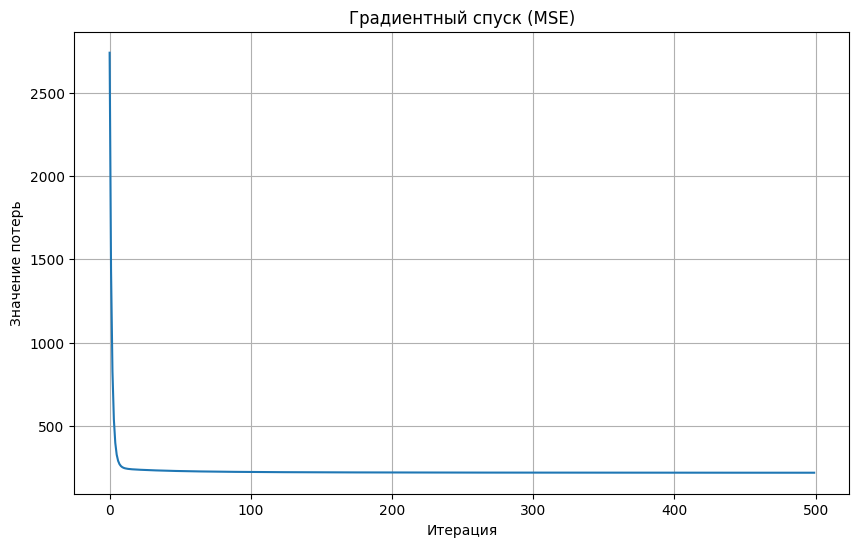

In [119]:
#lr = 0.1
model_gradient_scale['model'].plot_loss()

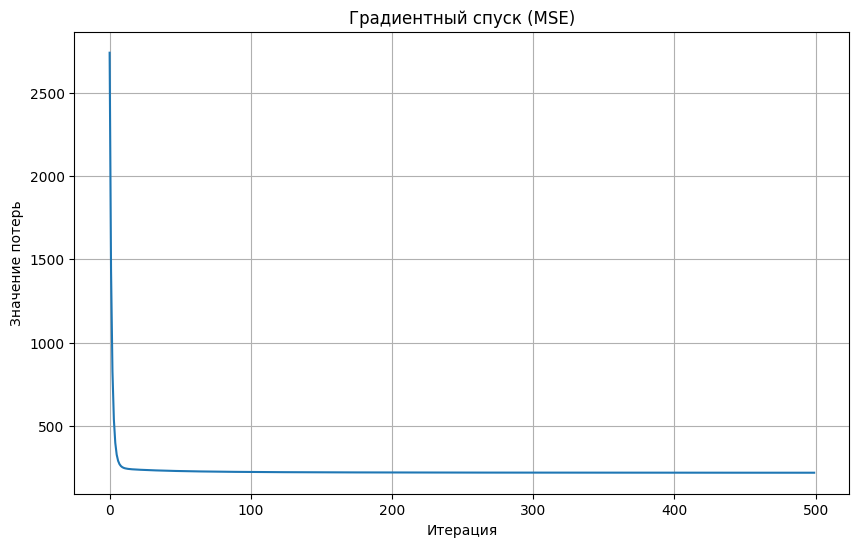

In [120]:
#lr = 0.01
model_gradient_scale['model'].plot_loss()

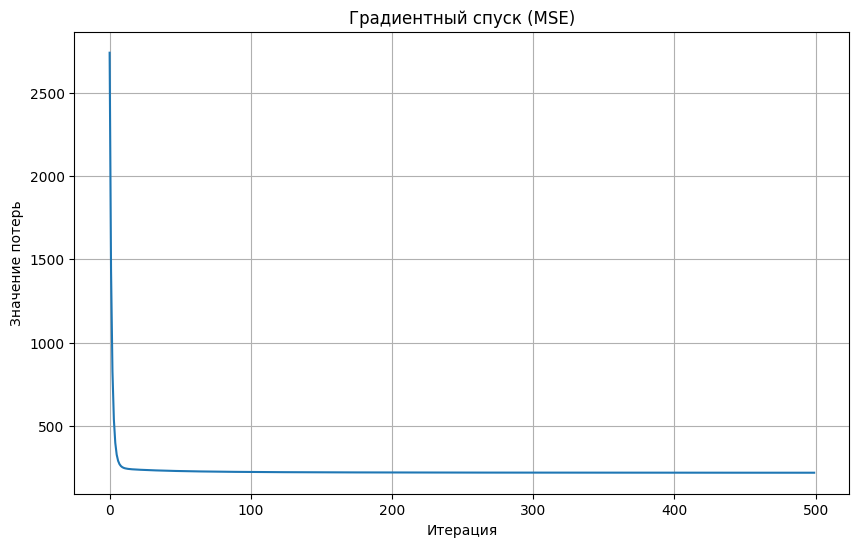

In [121]:
# lr = 0.0001
model_gradient_scale['model'].plot_loss()

In [122]:
show_all_regressor_metrics(y_pred=y_pred, y_test=y_test)

R2 - 0.6649564526601858
MSE - 222.58553243441585
RMSE - 14.919300668409893
45.50606824061257


#### Уберем  Podcat_name, Episode - кат фичи с множнством уникальных значений 

In [123]:
model_gradient_with_drop_podcast_name, y = make_pipeline_preprocessor_and_model(num_col=numeric_features_columns, cat_col=cat_features_columns[2:], target=y, model_class=NewLinearRegression, params=params_grad, scaler=True)

In [124]:
X.iloc[:,2:]

,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,99.25,Health,21.37,Thursday,Night,70.22,3,Positive
1,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral
2,117.03,News,96.33,Sunday,Night,57.95,3,Neutral
3,16.97,True Crime,25.73,Monday,Night,24.19,0,Positive
4,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3,Positive
...,...,...,...,...,...,...,...,...
52495,24.81,Lifestyle,66.15,Monday,Evening,98.63,1,Neutral
52496,92.15,Music,89.61,Saturday,Night,25.82,2,Negative
52497,112.27,Comedy,26.33,Saturday,Night,55.29,0,Neutral
52498,NaN,Business,41.47,Wednesday,Afternoon,33.58,0,Neutral


In [125]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,2:], y, test_size=0.33, random_state=42)

In [126]:
model_gradient_with_drop_podcast_name.fit(X_train, y_train)

2025/09/03 00:03:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a50079a22d9944bc83e25f386cb0213b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/09/03 00:04:00 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integer

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [127]:
y_pred = model_gradient_with_drop_podcast_name.predict(X_test)

/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
2025/09/03 00:04:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) 

In [128]:
show_all_regressor_metrics(y_pred=y_pred, y_test=y_test)

R2 - 0.6655605007802456
MSE - 222.18423423456372
RMSE - 14.905845639700008
45.50606824061257


## Обучим модель только на кол-ых фичах

In [129]:
model_in_num_feat = make_pipeline_preprocessor_and_model(num_col=numeric_features_columns, cat_col=cat_features_columns[2:], target=y, model_class=NewLinearRegression, params=params_grad, scaler=True, only_num_feat=True)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X[numeric_features_columns[:1]], y, test_size=0.33, random_state=42)

In [131]:
show_all_regressor_metrics(y_pred=y_pred, y_test=y_test)

R2 - 0.6655605007802456
MSE - 222.18423423456372
RMSE - 14.905845639700008
45.50606824061257


In [132]:
model_in_num_feat.fit(X_train, y_train)

2025/09/03 00:04:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '86ed431842e948b48975645144e22694', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,steps,"[('preproc', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,steps,"[('imputer', ...), ('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [133]:
y_pred = model_in_num_feat.predict(X_test)

/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [134]:
show_all_regressor_metrics(y_pred=y_pred, y_test=y_test)

R2 - 0.6549931455589435
MSE - 229.20463623016317
RMSE - 15.139505811953148
45.50606824061257


In [135]:
params_grad

{'loss': 'mse', 'learning_rate': 0.1, 'n_iters': 500}

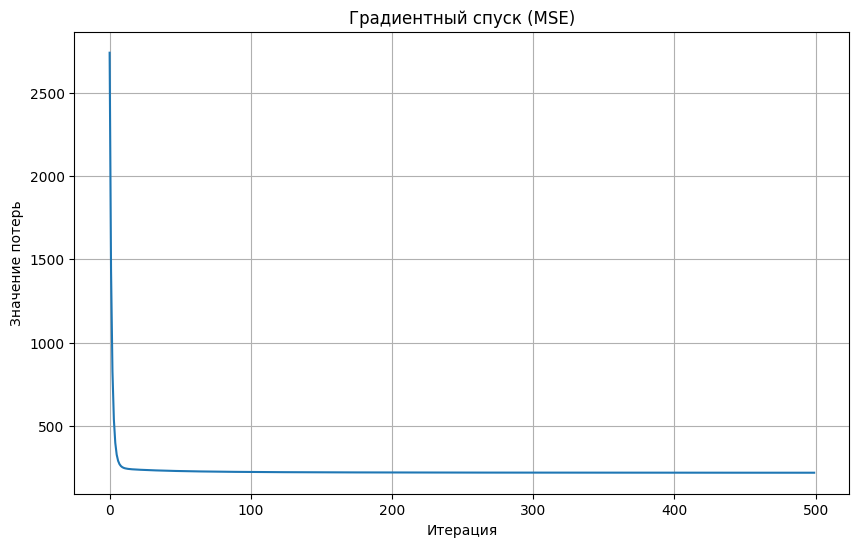

In [136]:
# lr = 0.1
model_gradient_scale['model'].plot_loss()

### Обучим случайный лес

In [137]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

In [138]:
random_forest = make_pipeline_preprocessor_and_model(num_col=numeric_features_columns, cat_col=cat_features_columns, model_class=RandomForestRegressor)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [140]:
random_forest.fit(X_train, y_train)

2025/09/03 00:04:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '042e7d5fa13843708ebbbb053d250ecd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2025/09/03 00:04:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: DataConversionWarning: A column-vector 

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [141]:
y_pred = random_forest.predict(X_test)

2025/09/03 00:05:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [142]:
random_forest['model'].feature_importances_.shape

(170,)

In [143]:
y_train_pred = random_forest.predict(X_train)

2025/09/03 00:05:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/poltava/Desktop/ML_practice/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


In [144]:
show_all_regressor_metrics(y_pred=y_train_pred, y_test=y_train)

R2 - 0.9540589056475476
MSE - 30.424394216359424
RMSE - 5.515831235304378
45.58700040093712


In [145]:
show_all_regressor_metrics(y_pred=y_pred, y_test=y_test)

R2 - 0.6706773420085295
MSE - 218.78487066459545
RMSE - 14.791378254395209
45.50606824061257
